## MiniLab Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Data preparation: Adjustments](#DataPrep)
    2. [Data preparation for Support Vector Machine](#SVGDataSet)

2. [Modeling and Evaluation](#ModelEvaluation)
    1. [Create a logistic regression model](#LRM)
    2. [Evaluation of logistic regression model](#LRMEval)
    3. [Support Vector Machine model](#SVG)
    4. [SVG evaluation](#SVGEval)
    5. [Discuss the advantages of each model for each classification task](#Advantages)
    6. [Use the weights from logistic regression to interpret the importance of features for each classification task](#Weights)
    7. [Look at the chosen support vectors for the classification task. Do these provide any insight into the data?](#SVGInsights) 
    8. [Additional Model: Gradient Boosted Decision Tree (GBDT)](#GBDT)
3. [Modeling Conclusions](#Conclusions)
4. [Next Stage Deployment](#Deployment)


# Mel Schwan, Stuart Miller, Justin Howard, Paul Adams
# Mini Lab: Logistic Regression and Support Vector Machine

In MiniLab2 we will perform predictive analysis (classification) upon a data set we cleaned in the Lab1. We will model the dataset using methods we have discussed in class. Logistic regression and support vector machines will be used in making conclusions from the analysis. The following phases of CRISP will be documented it the notebook.


<img src="../_images/crisps-dm-minilab.png" style="width:550px;height:450px"/>


# 1. Stage Three - Data Preparation (Q1)   <a class="anchor" id="DataPreparation"></a>

To produce useful descriptive and predictive models, our team found it necessary to systematically re-examine assumptions we previously held. During our modeling process, we built and evaluated models, used these evaluations to introduce changes to the dataset and applied treatments to the data, and progressively move toward more useful models. 
The product of the Data Preparation and Modeling Phases produced valuable insights into our dataset:
1. We discovered unfounded bias against features we previously deemed less useful
2. We found it necessary to research and experiment with a variety of sampling techniques

## 1.1 Data preparation: Adjustments (Q1A)<a class="anchor" id="DataPrep"></a>

The dataset we are analyzing consists of a mixture of attributes scraped from loan applications and credit bureaus. Overall, the dataset is sparsely populated due to Home Credit's focus on applicants with little to no credit history. 

**Assumption Changes:**
1. The EXTERNAL_SOURCE_1 and OWN_CAR_AGE features contribute significantly to a predictive model and were re-introduced to the dataset.
2. The CNT_FAM_MEMBERS, CNT_CHILDREN, CREDIT_ACTIVE, LOAN_COUNT were more valuable as binned categorical features than as high-cardinality integer counts.
3. Using under-sampling techniques produced better results than over-sampling techniques did.



In [1]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# others
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions
from sklearn.metrics import roc_curve, auc

# custom functions
from project_code.cleaning import read_clean_data, impute_data
from project_code.tables import classification_report

# set random seed
random_state = 1
np.random.seed(random_state)

Using TensorFlow backend.


In [2]:
# loading data that was preprocessed using the custom read_clean_data() function, 
# merged with the previously engineered newFeatures from Lab 1 

data = pd.read_csv('data.csv', na_values = 'XNA')

**Reducing High Cardinality Features**

In [3]:
data.CNT_FAM_MEMBERS.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])

The dataset contains features, such as the number of children an applicant has, where the number of unique values is relatively high. Still, the percentage of total makeup is almost imperceptible. The distributions of these high cardinality variables are heavily skewed. We tried to address this issue by reducing the number of numeric categories to get a more accurate interpretation of their impact on the target variable.

In [4]:
#recoding high cardinality features

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'
data['cnt_child'] = data.CNT_CHILDREN.apply(cnt_child).astype('category')

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'
data['cnt_family'] = data.CNT_FAM_MEMBERS.apply(cnt_family).astype('category')

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'
data['credit_active'] = data.CREDIT_ACTIVE.apply(credit_active).astype('category')

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'

data['loan_cnt'] = data.LOAN_COUNT.apply(loan_count).astype('category')

In [5]:
data.shape

(307511, 94)

### 1.1.1 Second Principal Component Analysis

Our feature selection decisions prompted a review of the Principal Components to see if a more significant separation between the classes is evident. We dropped variables that seemed the least useful for this type of analysis. Next, we on-hot encoded to eliminate the duplication of categorical features that were already binary indicators.

In [6]:
# dropping variables that were deemed the least useful for analysis
new_df = data.copy().drop(['TARGET', 'SK_ID_CURR', 'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV', 'LOAN_COUNT',
                          'CREDIT_ACTIVE'], axis = 1)
# one-hot encoding
# adding drop_first = True eliminates the duplication of categorical features that are already binary indicators
new_df = pd.get_dummies(new_df, drop_first = True)
pd.options.display.max_columns = 400
new_df.describe()

,Unnamed: 0,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMPLOYED,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,PERCENT_EMPLOYED_TO_AGE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_Y,FLAG_EMP_PHONE_Y,FLAG_WORK_PHONE_Y,FLAG_CONT_MOBILE_Y,FLAG_PHONE_Y,FLAG_EMAIL_Y,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_None,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,REG_REGION_NOT_LIVE_REGION_Y,REG_REGION_NOT_WORK_REGION_Y,LIVE_REGION_NOT_WORK_REGION_Y,REG_CITY_NOT_LIVE_CITY_Y,REG_CITY_NOT_WORK_CITY_Y,LIVE_CITY_NOT_WORK_CITY_Y,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_None,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,

In [7]:
sc = StandardScaler()
sc.fit(new_df)
X_train_std = sc.transform(new_df) 
X_train_std.shape

(307511, 193)

After dropping the least useful variables and preforming a one-hot encoding, the resulting data set had an increase in the features from 92 to 192.

In [8]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nTop Ten Eigenvalues \n%s' % eigen_vals[0:9])


Top Ten Eigenvalues 
[8.05794362 3.69872521 3.37219416 3.07843586 2.74807889 2.50659303
 2.4647468  2.35817863 2.17330637]


In [9]:
# calculating the total var explained and cumulative variance
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse =True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)
len(cum_var_exp)
print("Variance Explained length: " + str(len(var_exp)), "\nCumulative Variance Explained length : " + str(len(cum_var_exp)))

Variance Explained length: 193 
Cumulative Variance Explained length : 193


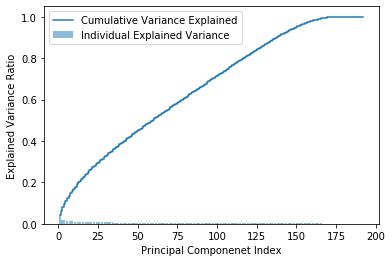

In [12]:
plt.bar(range(1,193), var_exp, alpha = .5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(1,193), cum_var_exp, where = 'mid', label = 'Cumulative Variance Explained')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Componenet Index')
plt.legend(loc='best')
plt.show()

**Significant Findings**

To capture at least 80% of the variability in the dataset, we must include around 125 principal components. While this is a large number of features, our previous dataset contained 302 features. Our efforts to reduce the cardinality of several features were effective. 

We will pair the eigenvectors with their corresponding eigenvalues and project them onto a 2-dimensional subspace and observe the results.

In [10]:
# making a listof (eigenvalues, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
"""eigen_pairs[0] is equivalent to the single eigenvalue for PC1 and the eigenvector that represents the 190 features of the data"""
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

#collecting the two eigenvectors that correspond to the two largest eigenvalues

W = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))

# printing the first 5 pairs
print('Matrix W: \n', W[:5])

Matrix W: 
 [[-0.0005874   0.00057723]
 [ 0.03506148  0.11586876]
 [ 0.03210579  0.26698581]
 [ 0.04883297  0.24819963]
 [ 0.00598885  0.17655421]]


We can use this matrix to transform the training set into new features and plot them. First, we will observe the first 2 Principal Components with a logistic regression-based decision boundary to view the discriminatory ability of a logistic model using the Principal Components.

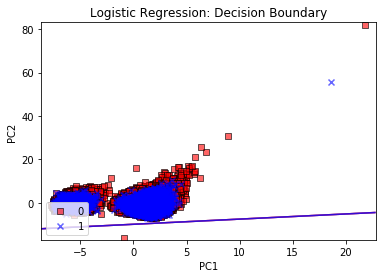

In [11]:
#transforming training data
X_train_pca = X_train_std.dot(W)

# identifying labels
y_train = data.TARGET

#initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components =2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
#fitting the logitistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

**Significant Findings**

From this plot, we can see that class separation is very poor and non-linear. We have two centroids where each has only a slight concentric-ellipse type of separation between the two classes. The decision boundary drawn by a logistic model is clearly unable to use the first two principal components to discriminate between defaults and non-defaulted loans.


We can also attempt to view the value of the third principal component to see if there is good separation when we add a third dimension.

In [12]:
# getting three principal components
W3 = np.hstack((W,eigen_pairs[2][1][:,np.newaxis]))
W3.shape

(193, 3)

In [13]:
#transforming training data
X_train_pca3 = X_train_std.dot(W3)
X_train_pca3.shape

(307511, 3)

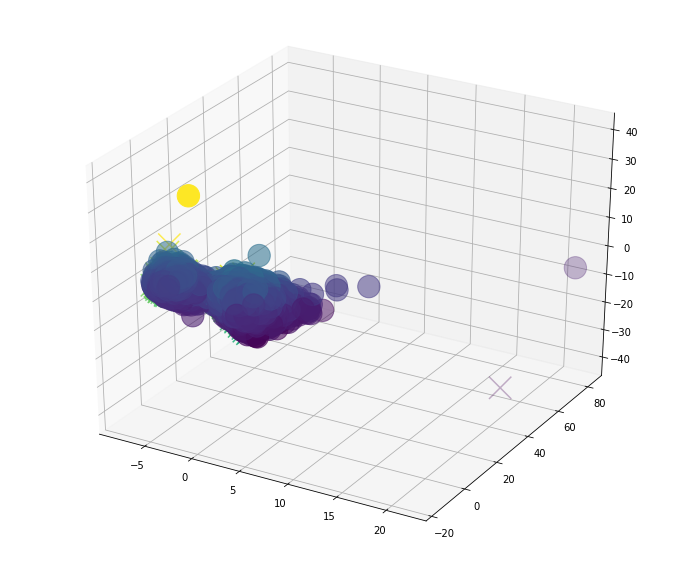

In [14]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')


colors = ['r','g']
markers = ['o', 'x']

# for each index and class in:
for idx, cl in enumerate(np.unique(y_train)):
    ax.scatter3D(X_train_pca3[y_train == cl, 0],
                X_train_pca3[y_train == cl, 1],
                X_train_pca3[y_train == cl, 2],
                label = cl,
                s=500,
                c = X_train_pca3[y_train == cl, 2],
                cmap = 'viridis',
                marker = markers[idx])

**Significant Findings**

A three dimensional plot of the data does provide some insights. Defaults can be separated along the third dimension, as indicated by the defaults being clustered in the blue region and the non-defaults being clustered in the green/yellow regions of the third Principal Component.

1. The overlap between the classes is so signficant even in the third dimension, that the boundary line is not clear.

2. We will apply sampling strategies that will clarify the class boundaries.

 ## 1.2 Data Preparation (Q1b) <a class="anchor" id="Dataprep"></a>

We combined multiple stratification and sampling techniques to the data before training the model:

1. Imputations are calculated based on the training set and applied to the test set.
2. A stratefied training/test set by `TARGET` : to guarantee similar distributions
3. Random-undersampling by the engineered categorical `CAT_INCOME` : clarify the boundaries between income strata
4. Tomek Link under-sampling by `TARGET` : clarify the boundaries between `TARGET` classes

### 1.2.1 Stratified Sampling by Incomes

Our first step is to separate the `AMT_INCOME_TOTAL` feature and create a new feature by dividing incomes into quantiles.

In [15]:
#create quantiles with simple category names based on the quantile ranges

income_labels = ['$25,659 - $112,500', '$112,500 - $147,150',
                 '$147,150 - $202,500','$202,500 - $117,000,000']

CAT_INCOME = pd.qcut(data['AMT_INCOME_TOTAL'], q = 4,
                    labels = income_labels)

CAT_INCOME.values

[$147,150 - $202,500, $202,500 - $117,000,000, $25,659 - $112,500, $112,500 - $147,150, $112,500 - $147,150, ..., $147,150 - $202,500, $25,659 - $112,500, $147,150 - $202,500, $147,150 - $202,500, $147,150 - $202,500]
Length: 307511
Categories (4, object): [$25,659 - $112,500 < $112,500 - $147,150 < $147,150 - $202,500 < $202,500 - $117,000,000]

In [16]:
# simplifying category names
data['CAT_INCOME'] = CAT_INCOME.astype('category')
#use the get_dummies function to quickly find the percentage of the dataset that each quantile makes up
pd.get_dummies(data.CAT_INCOME).describe()

,"$25,659 - $112,500","$112,500 - $147,150","$147,150 - $202,500","$202,500 - $117,000,000"
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.327071,0.172943,0.267350,0.232636
std,0.469144,0.378199,0.442577,0.422513
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


**Splitting the Data**

Now that we have the `CAT_INCOME` feature, we can gather the features we want to include in our model and form strata. 

Before we perform any sampling techniques, we must split our data into training and test sets. Our training set will consist of approximately 80% of the data, while the test set will be set aside for validation.
Imputation is only calculated based on the training data.

In [46]:
# read in the data without imputions that are distribution dependent
data = read_clean_data(preimpute = False)

In [47]:
# forming new dataset with target included. We will still drop features that we already decided were not useful.
strat_inc = data.copy().drop(labels = ['SK_ID_CURR','AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV'], axis = 1)
#print(list(strat_inc.columns))

Before we create our income strata, we will stratefy the training and test data by the `TARGET` variable to assure that class labels in both the training and test sets a distributed the same way.

In [48]:
# stratify the training and test sets by the target first
# must keep TARGET in the training sets at this point to under sample by income
y = strat_inc.TARGET
X = strat_inc
# setting random_state
random_state = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state, stratify = y)
print('y_train count: ' + str(y_train.count()) + '\ny_test count: ' + str(y_test.count()) +
      '\nTotal: ' + str(y_train.count() + y_test.count()))

y_train count: 246008
y_test count: 61503
Total: 307511


**Imputation**

The function `impute_data` calculates imputations values for the following values and applies these values to test set.
For categorical variables imputation of the mode was used.
For continuous variables imputation of the median was used.

| Variable | Imputation Method |
|----------|-------------------|
| CODE_GENDER | Mode |
| NAME_TYPE_SUITE | Mode |
| OBS_30_CNT_SOCIAL_CIRCLE | Median |
| DEF_30_CNT_SOCIAL_CIRCLE | Median |
| OBS_60_CNT_SOCIAL_CIRCLE | Median |
| DEF_60_CNT_SOCIAL_CIRCLE | Median |
| AMT_ANNUITY |  Median |
| ANNUITY_INCOME_RATIO |  Median |
| DAYS_LAST_PHONE_CHANGE |  Median |


In [49]:
X_train, X_test = impute_data(X_train, X_test)

# apply income splits
X_train.CAT_INCOME = pd.qcut(X_train['AMT_INCOME_TOTAL'], q = 4,
                             labels = income_labels)
X_test.CAT_INCOME = pd.qcut(X_test['AMT_INCOME_TOTAL'], q = 4,
                             labels = income_labels)

In [50]:
# combine the imputated test and train for analysis of the SVM
data_imputed = pd.concat([X_train, X_test])

**Creating Income Strata**

We will now take the training set and under-sample all the income categories except the majority category so that it is represented better.

In [21]:
# We are deciding to under sample all strata except the majority class
rus = RandomUnderSampler(random_state = random_state,
                         sampling_strategy = 'not majority')

# we are undersampling based on strata defined by the CAT_INCOME variable
y_inc = X_train.CAT_INCOME
X_rus, y_rus = rus.fit_resample(X_train,y_inc)
X_rus.shape

(207915, 75)

Now that we have applied an under-sampling strategy to make the majority income class more easily seperable, we can now under-sample by the `TARGET` feature to further clarify the boundary.

In [22]:
# preparing training data 

#removing TARGET from training data
y_train = X_rus.pop('TARGET')
#getting dummy variables
X_train = pd.get_dummies(X_rus, drop_first = True)


# preparing test data for evaluation
y_test = X_test.pop('TARGET')
# create SVM test set with out dummies
X_test_svm = X_test.copy()
# create test set with dummies
X_test = pd.get_dummies(X_test, drop_first = True)

# define a function to make empty features for missing features
cols = list(X_train.columns)
def add_missing_dummies(d, cols):
    missing_cols = set(cols) - set(d.columns)
    for c in missing_cols:
        d[c] = 0
add_missing_dummies(X_test, cols)

print('Shape of Training set: ' + str(X_train.shape) + '\nShape of Test set: ' + str(X_test.shape))

Shape of Training set: (207915, 176)
Shape of Test set: (61503, 176)


We will take the X_rus training data, which is randomly under-sampled by income and under-sample it once more according to the TomekLinks to make the boundary between the classes more evident.

In [23]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X_train, y_train)

**Resampling the Training Data**

Initially, the models were trained against training data that contained mostly non-defaulting instances. However, the model's performance on this initial training data was inferior, generally failing to classify any defaulting instances. The remedy to this issue was to resample the training data to balance the number of non-defaulting and defaulting instances. All the defaulting instances were retained, but the non-defaulting instances were randomly downsampled to match the number of non-defaulting instances. Resampled training data improved the performance of the models substantially when validated on the test data. 

The test data was **not** resampled.

Additionally, the categroical variables were label encoded, rather than one-hot encoded.

In [24]:
#removing TARGET from training data
y_train_SVM = y_train.copy()
#getting dummy variables
X_train_SVM = X_rus.copy()

In [25]:
# need to down sample to deal with training computation time
# training on whole set takes about 12hr
# use about 20% of the training data
downsampled = X_train_SVM.copy()
downsampled['TARGET'] = y_train_SVM

In [26]:
cols_encode = ['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START','OCCUPATION_TYPE',
              'NAME_FAMILY_STATUS','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE',
              'NAME_HOUSING_TYPE','NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

le = LabelEncoder()
for col in cols_encode:
    downsampled[col] = le.fit_transform(downsampled[col])
    X_test_svm[col] = le.transform(X_test_svm[col])

downsampled = downsampled.drop(labels = ['EXT_SOURCE_3','EXT_SOURCE_1','AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)
X_test_svm = X_test_svm.drop(labels = ['EXT_SOURCE_3','EXT_SOURCE_1','AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)


In [27]:
defaults = downsampled.query('TARGET == 1')
nominal = downsampled.query('TARGET == 0').sample(n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int),
                                                  random_state = random_state)
# join dataframes and shuffle
downsampled = pd.concat([defaults, nominal]).sample(frac = 1, 
                                                    random_state = random_state)

X_train_svm = downsampled.drop(labels = ['TARGET'], axis = 1)
y_train_svm = downsampled.TARGET

# transform the data
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

## 2.  Stage Four - Modeling and Evaluation (Q2) <a class="ModelEvaluation" id="EDA"></a>

## 2.1 Create a Logistic Regression Model (Q2A) <a class="anchor" id="LRM"></a>


Logistic regression is a classification model that performs well using linearly separable classes. In this case, our response classes – which refer to loan default status – are binary with a loan default represented with the integer 1 and non-default represented as integer 0. The logistic regression model utilizes an odds ratio, which represents the probability of an event occurring rather than an event not occurring.  In the case of this classification model, the event – also called a “positive event” – is a representation of a loan being defaulted. The produced odds ratio is then transformed logarithmically into a probability ranging from 0 to 1. Because there is a binary split in the classification of our output, the threshold for determining if a positive event has occurred or not is 0.5.

In both cases, the logistic regression models use an 80%-20% split between training and testing data, respectively. However, the second implementation of the logistic regression model applies a training set resampling to have 50% defaults and 50% non-defaults.

[Logistic Weights (Importance of Features)](#Weights) 

**Model 1**

In [28]:
logistic = LogisticRegression(solver='liblinear', random_state=1)#, C = whatever value the grid search picks)
logistic.fit(X_train, y_train);

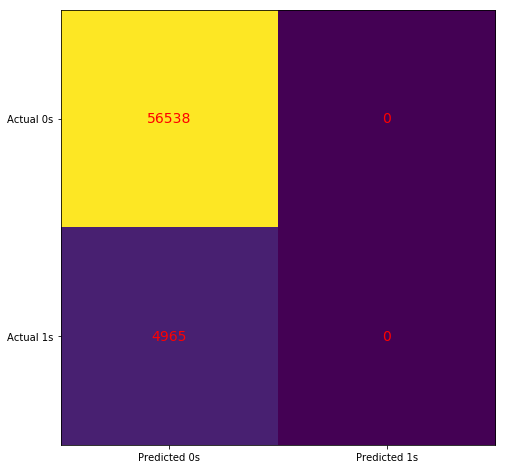

In [29]:
confused_matrix = confusion_matrix(y_test, logistic.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confused_matrix)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confused_matrix[i, j], ha='center', va='center', color='red', fontsize='14')
plt.show()

In [30]:
y_pred_log = logistic.predict(X_test)
print(classification_report(y_test, y_pred_log))

Classification Report

Confusion Matrix
Predicted      0    All
True                   
0          56538  56538
1           4965   4965
All        61503  61503

Accuracy: 91.93% 
Precision: 0.00% 
Recall: 0.00%
None


**Model 2**

In [31]:
logistic.fit(X_train_svm, y_train_svm);

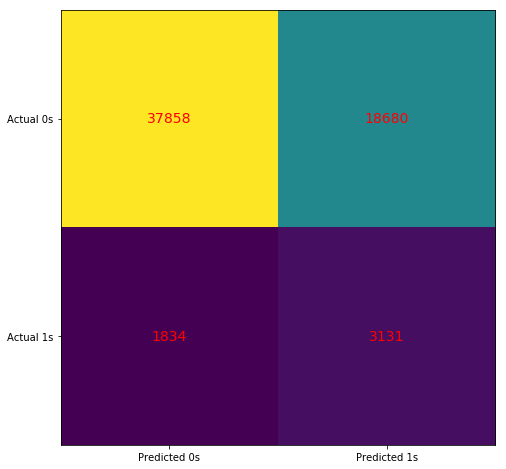

In [32]:
confused_matrix_svm_log = confusion_matrix(y_test, logistic.predict(X_test_svm))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confused_matrix_svm_log)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confused_matrix_svm_log[i, j], ha='center', va='center', color='red', fontsize='14')
plt.show()

**ROC Curve**

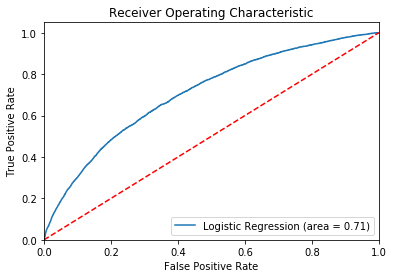

In [33]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test_svm)[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [34]:
y_pred_svm_log = logistic.predict(X_test_svm)
print(classification_report(y_test, y_pred_svm_log))

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          37858  18680  56538
1           1834   3131   4965
All        39692  21811  61503

Accuracy: 66.65% 
Precision: 14.36% 
Recall: 63.06%
None


### Tuning Logstic Regression

Performing grid search with cross validation on the training data for tuning did not yield better results. Because the results were not improved, we used the default regularization parameter, C = 1.

```Python
# scoring metrics 
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [{'C':np.logspace(-4, 4, 20)}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(random_state = random_state),
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
# Fit on data
best_clf = clf.fit(X_train_svm, y_train_svm)
```

```
Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.012742749857031334}

Grid scores on development set:

0.644 (+/-0.005) for {'C': 0.0001}
0.646 (+/-0.006) for {'C': 0.00026366508987303583}
0.647 (+/-0.007) for {'C': 0.0006951927961775605}
0.648 (+/-0.009) for {'C': 0.0018329807108324356}
0.648 (+/-0.007) for {'C': 0.004832930238571752}
0.648 (+/-0.007) for {'C': 0.012742749857031334}
0.648 (+/-0.007) for {'C': 0.03359818286283781}
0.648 (+/-0.008) for {'C': 0.08858667904100823}
0.648 (+/-0.007) for {'C': 0.23357214690901212}
0.648 (+/-0.007) for {'C': 0.615848211066026}
0.648 (+/-0.007) for {'C': 1.623776739188721}
0.648 (+/-0.007) for {'C': 4.281332398719396}
0.648 (+/-0.007) for {'C': 11.288378916846883}
0.648 (+/-0.007) for {'C': 29.763514416313132}
0.648 (+/-0.008) for {'C': 78.47599703514607}
0.648 (+/-0.007) for {'C': 206.913808111479}
0.648 (+/-0.007) for {'C': 545.5594781168514}
0.648 (+/-0.007) for {'C': 1438.44988828766}
0.648 (+/-0.007) for {'C': 3792.690190732246}
0.648 (+/-0.007) for {'C': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          37858  18680  56538
1           1838   3127   4965
All        39696  21807  61503

Accuracy: 66.64% 
Precision: 14.34% 
Recall: 62.98%
None

Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.012742749857031334}

Grid scores on development set:

0.644 (+/-0.005) for {'C': 0.0001}
0.646 (+/-0.006) for {'C': 0.00026366508987303583}
0.647 (+/-0.007) for {'C': 0.0006951927961775605}
0.648 (+/-0.008) for {'C': 0.0018329807108324356}
0.648 (+/-0.007) for {'C': 0.004832930238571752}
0.648 (+/-0.007) for {'C': 0.012742749857031334}
0.648 (+/-0.007) for {'C': 0.03359818286283781}
0.648 (+/-0.007) for {'C': 0.08858667904100823}
0.648 (+/-0.007) for {'C': 0.23357214690901212}
0.648 (+/-0.007) for {'C': 0.615848211066026}
0.648 (+/-0.007) for {'C': 1.623776739188721}
0.648 (+/-0.007) for {'C': 4.281332398719396}
0.648 (+/-0.007) for {'C': 11.288378916846883}
0.648 (+/-0.007) for {'C': 29.763514416313132}
0.648 (+/-0.007) for {'C': 78.47599703514607}
0.648 (+/-0.007) for {'C': 206.913808111479}
0.648 (+/-0.007) for {'C': 545.5594781168514}
0.648 (+/-0.007) for {'C': 1438.44988828766}
0.648 (+/-0.007) for {'C': 3792.690190732246}
0.648 (+/-0.007) for {'C': 10000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          37858  18680  56538
1           1838   3127   4965
All        39696  21807  61503

Accuracy: 66.64% 
Precision: 14.34% 
Recall: 62.98%
None
```

## 2.2 Evaluation of Logistic Regression Model (Q2B) <a class="anchor" id="LRMEval"></a>

The first application of the logistic regression model produced poor results. Precision and recall were both recorded at 0% with an accuracy of 91.93%.

The results of the second model were much improved; 14.36% precision and 63.06% recall was recorded with a 66.65% accuracy. The contrast of the two logistic regression models assisted in understanding how resampling impacts the results of the algorithm.

## 2.3  Support Vector Machine Model (Q2C) <a class="anchor" id="SVG"></a>



A support vector machine (SVM) was used to model this data. Specifically, Sci-Kit Learn's support vector classifier implementation was used for this modeling. The model was unable to predict the target classes when trained on the nominal training data. However, model prediction ability improved when training utilizing the resampled data (described above).

This model provided a precision of 14.67% and a recall of 60.77% when trained with the best model parameters and validated on the test data.

In [40]:
# train svm
# `probability` is set for ROC calculation takes ~1.25 hr to run
svc = SVC(C = 1.1, kernel = 'linear', probability = True, random_state = random_state)
svc.fit(X_train_svm, y_train_svm)
y_pred_svm = svc.predict(X_test_svm)

In [41]:
classification_report(y_test, y_pred_svm)

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38989  17549  56538
1           1948   3017   4965
All        40937  20566  61503

Accuracy: 68.30% 
Precision: 14.67% 
Recall: 60.77%


### Tuning SVM

The SVM was tuned using a grid search with cross validation on the training data for the best regularization parameter `C` and the best option for `kernel`.
Due to the long compute time of training an SVM, a limited range of value were searched for the best regularization parameter.
`GridSearchCV` from Sci-Kit Learn was used for searching for the best model parameters.
Precision and recall were used to score the model during the search.

A value of 0.5 for `C` and the linear option `kernel` were chosen as the best hyperparameters by grid search.

```python
scores = ['precision', 'recall']

# tuning parameters
tuned_parameters = [{'C':[0.5, 0.75, 1.0, 1.25, 1.5],
                    'kernel': ['linear', 'rbf']}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(random_state = 42),
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    clf_report(y_true, y_pred)
    print()
```

```
Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.5, 'kernel': 'linear'}

Grid scores on development set:

0.647 (+/-0.006) for {'C': 0.5, 'kernel': 'linear'}
0.647 (+/-0.008) for {'C': 0.5, 'kernel': 'rbf'}
0.647 (+/-0.006) for {'C': 0.75, 'kernel': 'linear'}
0.645 (+/-0.009) for {'C': 0.75, 'kernel': 'rbf'}
0.647 (+/-0.006) for {'C': 1.0, 'kernel': 'linear'}
0.644 (+/-0.010) for {'C': 1.0, 'kernel': 'rbf'}
0.647 (+/-0.006) for {'C': 1.25, 'kernel': 'linear'}
0.644 (+/-0.011) for {'C': 1.25, 'kernel': 'rbf'}
0.647 (+/-0.006) for {'C': 1.5, 'kernel': 'linear'}
0.644 (+/-0.012) for {'C': 1.5, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38988  17550  56538
1           1948   3017   4965
All        40936  20567  61503

Accuracy: 68.30% 
Precision: 14.67% 
Recall: 60.77%

Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.5, 'kernel': 'linear'}

Grid scores on development set:

0.646 (+/-0.005) for {'C': 0.5, 'kernel': 'linear'}
0.646 (+/-0.008) for {'C': 0.5, 'kernel': 'rbf'}
0.646 (+/-0.006) for {'C': 0.75, 'kernel': 'linear'}
0.645 (+/-0.009) for {'C': 0.75, 'kernel': 'rbf'}
0.646 (+/-0.005) for {'C': 1.0, 'kernel': 'linear'}
0.644 (+/-0.010) for {'C': 1.0, 'kernel': 'rbf'}
0.646 (+/-0.005) for {'C': 1.25, 'kernel': 'linear'}
0.644 (+/-0.011) for {'C': 1.25, 'kernel': 'rbf'}
0.646 (+/-0.005) for {'C': 1.5, 'kernel': 'linear'}
0.644 (+/-0.011) for {'C': 1.5, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38988  17550  56538
1           1948   3017   4965
All        40936  20567  61503

Accuracy: 68.30% 
Precision: 14.67% 
Recall: 60.77%
```

**ROC Curve**

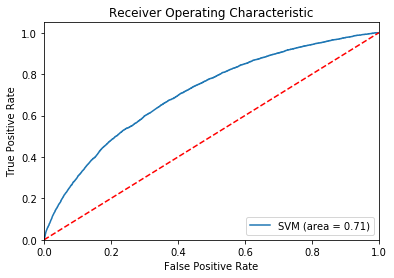

In [44]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(X_test_svm)[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'SVM (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## 2.4 SVM Evaluation (Q2D) <a class="anchor" id="SVGEval"></a>

Based on an analysis of the support vectors, the SVM had difficulty splitting the data based on the target varaible.
78% of the instances in the training data were selected as support vectors.
This indicates that there are a large number of misclassicaitions due to the difficulty in separating the features based on the target variable.

Kernel density estimates (KDE) of the feature distributions for the support vectors and the original data are shown below.
Visually, there is litte difference between the distributions of the support factors and the original data.
For instance, the distributions of `DAYS_ID_PUBLISH` appear to be almost the same.
The feature `REGION_POPULATION_RELATIVE` appears to show the most difference in distributions - 
some of the distribution peaks change in magnitude between the support vectors and the original data.
If the data was more separable, we would expect to see differences in the KDEs for the original data,
and strong similarity in the KDEs for the support vectors.

Note: The log of `AMT_INCOME_TOTAL` was used due do the scale of `AMT_INCOME_TOTAL`.

In [42]:
print('{} instances were used for training.'.format(X_train_svm.shape[0]))
print('{} of the training instances were chosen as support vectors.'.format(len(svc.support_)))
percent = len(svc.support_) / X_train_svm.shape[0] * 100
print('{:0.1f}% of the instances in the training data were chosen as suppor vectors'.format(percent)) 

33748 instances were used for training.
26310 of the training instances were chosen as support vectors.
78.0% of the instances in the training data were chosen as suppor vectors


In [52]:
# get the support vectors
data_support = data_imputed.iloc[svc.support_,:].copy()

data_imputed['AMT_INCOME_TOTAL_log'] = np.log(data_imputed.AMT_INCOME_TOTAL)
data_support['AMT_INCOME_TOTAL_log'] = np.log(data_support.AMT_INCOME_TOTAL)

# group the original data and the support vectors by the target variable
df_grouped_support = data_support.groupby(['TARGET'])
df_grouped = data_imputed.groupby(['TARGET'])

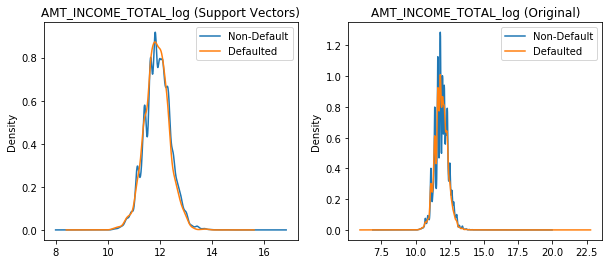

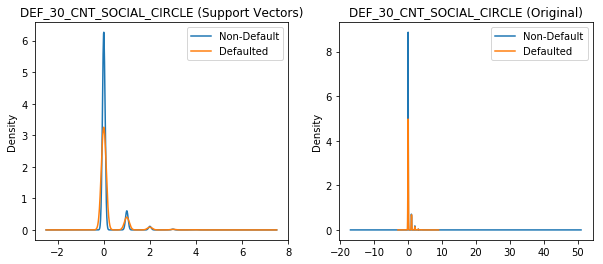

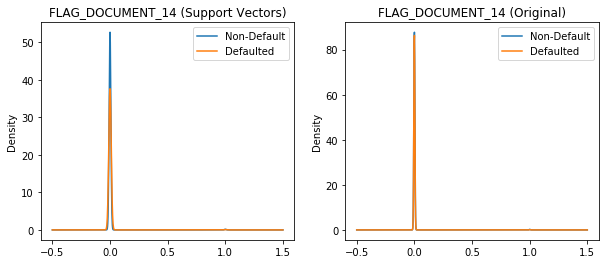

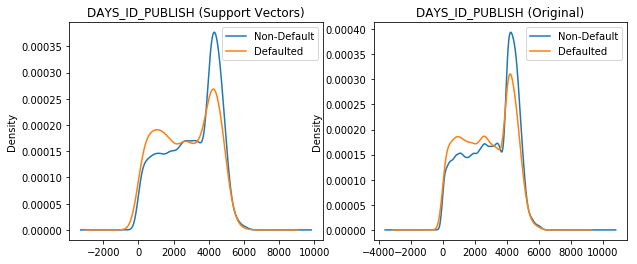

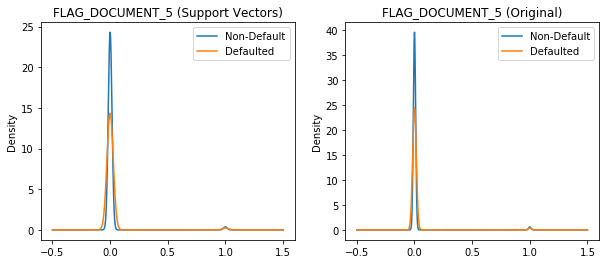

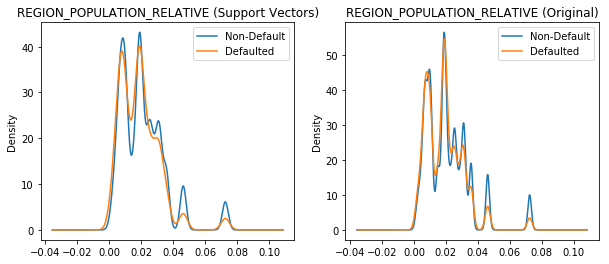

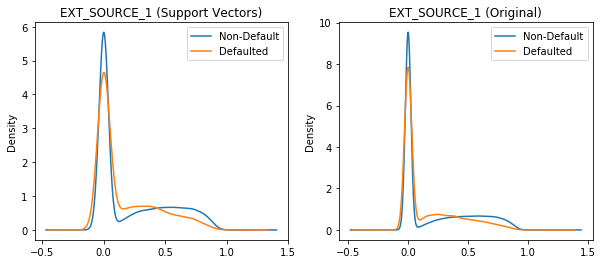

In [53]:
# plot kdes of some of the important features as selected by logistic regression
vars_to_plot = ['AMT_INCOME_TOTAL_log', 
                'DEF_30_CNT_SOCIAL_CIRCLE',
                'FLAG_DOCUMENT_14',
                'DAYS_ID_PUBLISH', 
                'FLAG_DOCUMENT_5', 
                'REGION_POPULATION_RELATIVE', 
                'EXT_SOURCE_1']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Non-Default','Defaulted'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Non-Default','Defaulted'])
    plt.title(v+' (Original)')

## 2.5 Discuss the advantages of each model for each classification task (Q2E) <a class="anchor" id="Advantages"></a>

We assembled a summative table of the advantages and disadvantages of three modeling strategies. The third model, a Histogram-Based Gradient Boosted Decision Tree, is discussed with greater detail in section [2.8 Additional Models](#GBDT).



|  | **Logistic Model** | **Support Vector Machines** | **Histogram Based Gradient Boosting Machines** |
|:--:|:----------------|:-----------------------|:-------------------------------------------|
| **Advantages** | Analyzing coefficients serves as both a descriptive and non-descriptive form and data analysis. While the Logistic Regression model was not our most highly performing model, an anlysis of the weights served to validate previous findings in regard to feature important and provided insights to features that became inpornant was we changed our sampling strategies. | High degree of both precision and recall with non-linearly seperable data. | A balance of accuracy and training speed. This model offered training speeds similar to the Logistic Regression model and provided gains in the recall metric. |
| **Disadvantages** | Not as apt to accurately classify non-linearly separable data. | Very computationally intense. Long Training times. | Difficult to interpret the results of the model. |

## 2.6 Use the weights from logistic regression to interpret the importance of features for each classification task (Q2F) <a class="anchor" id="Weights"></a>

Below are the top 10 most meaningful features used by the logistic regression model. The first five of the below are the most significant features inversely related to the positive outcome (loan default). In contrast, the last five features are directly associated with the positive result. In other words, the first five features below influence a loan's non-default status, whereas the previous five features influence a loan's default status.

Using AMT_INCOME_TOTAL as one example, as an applicant earns higher income,
the applicant is less likely to default on a loan.
Using REGION_POPULATION_RELATIVE (population density) as another example,
the larger the population density where the applicant lives,
the more likely the applicant is to default on a loan.

In [61]:
coefs = logistic.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X_train.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic = df_new_coeffs.sort_values('Logistic Weight')
final_head = final_df_logistic.head(10)
final_tail = final_df_logistic.tail(10)
final_weights = pd.concat([final_head, final_tail], axis=0)
print(final_weights.to_string(index=False))

                    Feature  Logistic Weight
            FLAG_DOCUMENT_4        -0.470529
           AMT_INCOME_TOTAL        -0.177277
            FLAG_DOCUMENT_7        -0.143657
                 AMT_CREDIT        -0.136766
            FLAG_WORK_PHONE        -0.135893
          FLAG_OWN_REALTY_Y        -0.132881
    LIVE_CITY_NOT_WORK_CITY        -0.112620
                 FLAG_EMAIL        -0.105989
                 DAYS_BIRTH        -0.087642
   OBS_60_CNT_SOCIAL_CIRCLE        -0.085004
           FLAG_DOCUMENT_10         0.075741
 REG_REGION_NOT_LIVE_REGION         0.079989
            FLAG_DOCUMENT_6         0.096660
   DEF_30_CNT_SOCIAL_CIRCLE         0.102698
           FLAG_DOCUMENT_14         0.103766
            DAYS_ID_PUBLISH         0.142095
            FLAG_DOCUMENT_5         0.152373
 REGION_POPULATION_RELATIVE         0.181277
               EXT_SOURCE_1         0.199204
           FLAG_DOCUMENT_11         0.212186


## 2.7 Look at the chosen support vectors for the classification task. Do these provide any insight into the data? (Q2G) <a class="anchor" id="SVGInsights"></a>


The SVM chose 78% of the instances in the training data as support vectors.
This indicates that the data is very difficult to split with hyperplanes.
The support vectors represent the data points that lie closest to the decision surface.
This means that most of the instances in the training data lie close to the decision surface,
indicating that the SVM had difficulty separating the data based on the target variable.
We suspect that we may not have the right variable to make good predictions on the target variable 
or more complex variable interactions are necessary to produce good separation.

As discussed in [section 2.4](#SVGEval), 
there is litte difference between the distributions of the support vectors 
and the original data.

## 2.8 Additional Models: Gradient Boosted Decision Tree (GBDT) <a class="anchor" id = "GBDT"></a>

In addition to the required Logsitic Regression and Support Vector Classifiers, we trained a Gradient Boosted Decsion Tree using sklearn's experimental HistGradientBoostingCalssifier. The primary benefit of this modeling strategy is that histogram-based estimators can be orders of magnitude faster than regular Gradient Boosting Classifiers whe nthe number of samples is as large as our dataset. There is also little need for imputing values. 

In [25]:
# comparing the training set that is under sampled by income AND undersampled by the tomeklinks along the boundary between classes
clf = HistGradientBoostingClassifier(random_state = random_state).fit(X_tl, y_tl)
#cross_val_score(clf, X_tl, y_tl, cv = 5, scoring = 'recall')

In [32]:
# using it on test set
y_pred = clf.predict(X_test)
results = confusion_matrix(y_test, y_pred)

accuracy = (results[0][0] + results[1][1])/(len(y_pred))
precision = results[1][1]/(results[0][1] + results[1][1])
recall = results[1][1]/ (results[1][0] + results[1][1])

print(results,
      '\nAccuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

[[56520    18]
 [ 4940    25]] 
Accuracy: 0.919386046209128 
Precision: 0.5813953488372093 
Recall: 0.005035246727089627


The results are slightly better than the other models we have used on the unbalanced data. A Grid Search will be conducted to tune the hyper-parameters.

### Tuning Hist-Gradient Boosting Machine

In [ ]:
#grid search
g_clf = HistGradientBoostingClassifier(random_state = random_state)

grid_values = {
    'loss': ['binary_crossentropy', 'categorical_crossentropy'],
    'learning_rate': [.2, .1],
    'max_iter': [100, 150],
    'max_leaf_nodes': [31, 41],
    'min_samples_leaf': [20, 30],
    'l2_regularization':[0,.01],
    'random_state': [random_state]
}

grid_clf = GridSearchCV(g_clf, param_grid = grid_values)

grid_clf.fit(X_tl, y_tl)

In [104]:
y_pred = grid_clf.predict(X_test)
results = confusion_matrix(y_test, y_pred)

accuracy = (results[0][0] + results[1][1])/(len(y_pred))
precision = results[1][1]/(results[0][1] + results[1][1])
recall = results[1][1]/ (results[1][0] + results[1][1])

print(results,
      '\nAccuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

[[56482    56]
 [ 4897    68]] 
Accuracy: 0.9194673430564363 
Precision: 0.5483870967741935 
Recall: 0.013695871097683786


In [106]:
print(grid_clf.best_params_)

{'l2_regularization': 0, 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'max_iter': 100, 'max_leaf_nodes': 41, 'min_samples_leaf': 20, 'random_state': 1}


**ROC Curve**

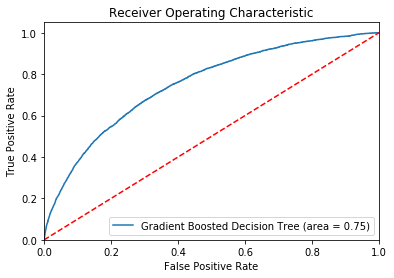

In [121]:

#get raw probabilities for y
y_score = grid_clf.decision_function(X_test)

# Compute ROC curve and AUC for each class

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict()


fpr, tpr, thresholds = roc_curve(y_test, grid_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Gradient Boosted Decision Tree (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()


This model was trained on data that was downsampled based on income quantiles and down-sampled again based on Tomek Links among the two target classes. A grid search was conducted to select the most appropriate hyper-parameters for the data. Due to long training times, we chose to limit the scope of the Grid Search to two selections over seven possible parameters, which would result in a very large number of combinations. The Grid Search selected binary cross entropy as the loss function and the larger option for leaf nodes, which was 41. The Grid Search selected the default values for the five other possible parameters. 

**Significant Findings**

1. After tuning the model using a Grid Search, the recall of the tuned model rose to 1.37%. 
2. The Histogram Based Gradient Boosted Machines algorithm does return the best recall of all the models we selected on the unbalanced dataset. 

We are convinced that randomly under-sampling the majority class to balance the training data is the most effective approach to training a model capable of providing useful loan default predictions. 

## 3.0 Modeling Conclusions (Q3) <a class="anchor" id="Conclusions"></a>

The three models were used to predict loan defaults: Logistic Regression, Support Vector Machines, and a Histogram-Based Gradient Boosted Decision Tree. The models displayed represent a combination of approaches to a diverse, highly unbalanced dataset. Among the most significant findings was the power of applying an appropriate sampling strategy. Before applying a range of sampling strategies, our models' recall consistently under-performed. We discovered that undersampling the majority class to provide a better class balance provided the most gain in achieving our goal of detecting defaults. Training a model on all of the defaults, randomly selecting an equal number of non-default loans, and performing a Grid Search for hyper-parameter optimization was the best means to achieving higher recall metrics.

## 4.0 Next Stage Deployment <a class="anchor" id="Deployment"></a>

The next stage in the CRISP-DM is deployment. After model building and evaluation, we are ready to deploy our code representation of the model into a production environment and solve our original business problem.
Our business problem is to give Home Credit loan evaluators access to a model that evaluates an applicant’s current and past financial history in determining whether to approve the requested loan.

The models that we have developed above will be used to determine this business question. Depending on the resources,  available, models can be deployed as batch or real-time predictions. Home Credits current process is a batch implementation. The applicant fills out the form which is then digitized and sent to the loan approval department. During the loan approval, the collected data will need to be cleaned and normalized before processed through the machine learning predictive model. The metrics for the customer is continually updated. On a scheduled cycle, this new dataset is analyzed through the current model. Doing batch cycles will allow for consistency in whether an applicant is approved or not.

However, model designs will change as newer technology are available or changing business environments make reengineering required.

Below is a typical example of a batch deployment \[1\].

<img src="../_images/batchdeployment_process.png" style="width:800px;height:375px"/>

## References

\[1\] J. Kervizic, Overview of Different Approaches to Deploying Machine Learning Models in Production, June 2016.
Accessed on: Feb. 15, 2019. \[Online\].
Available: https://www.kdnuggets.com/2019/06/approaches-deploying-machine-learning-production.html
